# NYC Collision Data Analysis

## Peak times for traffic related casualties in New York City

> What month of the year? 
  ...what day of the week?
  ...what time of day?   
  Has the most human casualties on New York's streets?  
    

I've spent considerable time walking, biking, driving and taking public transport in this busy city. Just like many New Yorkers, I've also had numerous close calls with vehicles while crossing wide streets, where traffic turns onto your crossing lane as you try to make it to the other side in one piece. 

Using the information provided by [NYC Open Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95), I wanted to find out when most human casualty causing collisions occur, and how I could best present that information. 

:::{.callout-tip}
You can skip the explanations and go straight to [the results](#what-was-the-worst-year-for-traffic-collision-casualties).  
or,   
You can read on and see how I came up with these numbers.
:::


:::{.callout-note}

### Technology Used

- [Python](https://www.python.org/)
- [Jupyter Notebook](https://jupyter.org/)
- [pandas](https://pandas.pydata.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [Seaborn](https://seaborn.pydata.org/)
- [nbdev](https://nbdev.fast.ai/)
:::


### The Setup

In [ ]:
# | code-fold: true
# | code-summary: Code - Import All Required Python Modules

import datetime
from pathlib import Path

import matplotlib.pyplot as plt

# Import All Required Python Modules
import numpy as np
import pandas as pd
import seaborn as sns

In [ ]:
# | code-fold: true
# | code-summary: Code - Data Formatting Functions
# Data Formatting Functions


def empty_to_zero(val):
    """Converts empty values to 0"""
    val = val.strip("\s+")
    return val if len(val) else 0


def convert_to_numeric(df, column_list):
    """Given a list of DataFrame columns, it converts the empty values to zero"""
    df[column_list] = df[column_list].apply(pd.to_numeric, errors="coerce")

In [ ]:
# | code-fold: true
# | code-summary: Code - Set Up Some Global Variables
# Set Up Some Global Variables

# I'm omitting longitude, latitude, the vehicle types as well as crash contributing factors.
cols_requested = [
    "COLLISION_ID",
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "ZIP CODE",
    "LOCATION",
    "ON STREET NAME",
    "CROSS STREET NAME",
    "OFF STREET NAME",
    "NUMBER OF PERSONS INJURED",
    "NUMBER OF PERSONS KILLED",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "NUMBER OF CYCLIST INJURED",
    "NUMBER OF CYCLIST KILLED",
    "NUMBER OF MOTORIST INJURED",
    "NUMBER OF MOTORIST KILLED",
]

# To ensure that the colums are of the expected data type
crash_dtypes = {
    "CRASH DATE": str,
    "CRASH TIME": str,
    "BOROUGH": str,
    "ZIP CODE": str,
    "LOCATION": str,
    "ON STREET NAME": str,
    "CROSS STREET NAME": str,
    "OFF STREET NAME": str,
}

# Rename some colums to ones that I believe are shorter and/or more meaningful
cols_rename = {
    "CRASH DATE": "DATE",
    "CRASH TIME": "TIME",
    "ZIP CODE": "ZIP_CODE",
    "ON STREET NAME": "ON_STREET_NAME",
    "CROSS STREET NAME": "CROSS_STREET_NAME",
    "OFF STREET NAME": "OFF_STREET_NAME",
    "NUMBER OF PERSONS INJURED": "NUM_PERSONS_INJURED",
    "NUMBER OF PERSONS KILLED": "NUM_PERSONS_KILLED",
    "NUMBER OF PEDESTRIANS INJURED": "NUM_PEDESTRIANS_INJURED",
    "NUMBER OF PEDESTRIANS KILLED": "NUM_PEDESTRIANS_KILLED",
    "NUMBER OF CYCLIST INJURED": "NUM_CYCLISTS_INJURED",
    "NUMBER OF CYCLIST KILLED": "NUM_CYCLISTS_KILLED",
    "NUMBER OF MOTORIST INJURED": "NUM_MOTORISTS_INJURED",
    "NUMBER OF MOTORIST KILLED": "NUM_MOTORISTS_KILLED",
}

# Columns that contain numeric values
numeric_cols = [
    "NUM_PERSONS_INJURED",
    "NUM_PERSONS_KILLED",
    "NUM_PEDESTRIANS_INJURED",
    "NUM_PEDESTRIANS_KILLED",
    "NUM_CYCLISTS_INJURED",
    "NUM_CYCLISTS_KILLED",
    "NUM_MOTORISTS_INJURED",
    "NUM_MOTORISTS_KILLED",
]

# These ordered lists are useful for plotting charts
day_names_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]
day_abbr_order = [d[0:3] for d in day_names_order]
month_names_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
month_abbr_order = [m[0:3] for m in month_names_order]

# The following DataFrame columns that will have their empty values converted to zero using the
# 'empty_to_zero' function
convert_cols = {
    "NUMBER OF PERSONS INJURED": empty_to_zero,
    "NUMBER OF PERSONS KILLED": empty_to_zero,
    "NUMBER OF PEDESTRIANS INJURED": empty_to_zero,
    "NUMBER OF PEDESTRIANS KILLED": empty_to_zero,
    "NUMBER OF CYCLIST INJURED": empty_to_zero,
    "NUMBER OF CYCLIST KILLED": empty_to_zero,
    "NUMBER OF MOTORIST INJURED": empty_to_zero,
    "NUMBER OF MOTORIST KILLED": empty_to_zero,
}

# These are the 4 categories supplied by the NYPD
victim_categories = ["person", "cyclist", "motorist", "pedestrian"]
# 'person' status should be a combination of the other three categories
# TODO I need to verify the relationship between 'person' and the other three categories

# These are the Matplotlib Tableau colors
bar_colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan",
]

base_colors = ["b", "g", "r", "c", "m", "y", "k", "w"]

# Chart Colors
color = "k"
plt.rcParams["text.color"] = color
plt.rcParams["axes.labelcolor"] = color
plt.rcParams["xtick.color"] = "b"
plt.rcParams["ytick.color"] = "b"

### Get and Clean The Raw Data

#### Read the NYC collision data [CSV file](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95) into our Pandas DataFrame which I'll call, '*crash*'. 

In [ ]:
# | code-fold: true
# | code-summary: Code - Creating the 'crash' DataFrame from the NYPD CSV file.

collision_filename = "Motor_Vehicle_Collisions_Aug15_2023.csv"

# Using the Pandas 'read_csv' function
crash = pd.read_csv(
    Path.cwd().joinpath("..").joinpath(collision_filename),
    index_col="COLLISION_ID",
    usecols=cols_requested,
    dtype=crash_dtypes,
    converters=convert_cols,
)

In [ ]:
# | code-fold: true
# | code-summary: Rename some of the DataFrame columns

original_col_names = crash.columns.to_list()

# Rename the columns using the list of new names, 'cols_rename'
crash.rename(columns=cols_rename, inplace=True)

print("Original Crash Column Names\n{}".format(original_col_names))
print("\nRenamed Crash Columns Names\n{}".format(crash.columns.to_list()))

Original Crash Column Names
['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']

Renamed Crash Columns Names
['DATE', 'TIME', 'BOROUGH', 'ZIP_CODE', 'LOCATION', 'ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME', 'NUM_PERSONS_INJURED', 'NUM_PERSONS_KILLED', 'NUM_PEDESTRIANS_INJURED', 'NUM_PEDESTRIANS_KILLED', 'NUM_CYCLISTS_INJURED', 'NUM_CYCLISTS_KILLED', 'NUM_MOTORISTS_INJURED', 'NUM_MOTORISTS_KILLED']


In [ ]:
# | code-fold: true
# | code-summary: Code - Convert string values to numeric for specific 'numeric' columns.

# Ensure that the 'numeric_cols' column values are numeric and not string values
convert_to_numeric(crash, numeric_cols)

In [ ]:
# | hide
crash.shape

(2017370, 16)

In [ ]:
# | hide
crash.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2017370 entries, 4455765 to 4647913
Data columns (total 16 columns):
 #   Column                   Dtype 
---  ------                   ----- 
 0   DATE                     object
 1   TIME                     object
 2   BOROUGH                  object
 3   ZIP_CODE                 object
 4   LOCATION                 object
 5   ON_STREET_NAME           object
 6   CROSS_STREET_NAME        object
 7   OFF_STREET_NAME          object
 8   NUM_PERSONS_INJURED      int64 
 9   NUM_PERSONS_KILLED       int64 
 10  NUM_PEDESTRIANS_INJURED  int64 
 11  NUM_PEDESTRIANS_KILLED   int64 
 12  NUM_CYCLISTS_INJURED     int64 
 13  NUM_CYCLISTS_KILLED      int64 
 14  NUM_MOTORISTS_INJURED    int64 
 15  NUM_MOTORISTS_KILLED     int64 
dtypes: int64(8), object(8)
memory usage: 261.7+ MB


In [ ]:
# | code-fold: true
# | code-summary: Code - General Description of the 'crash' dataset

#  General Description of the dataset.

# The 'set_option' is used here to display numeric values as a 'float' rather
# than the default scientific notation
pd.set_option("display.float_format", lambda x: "%8.2f" % x)
crash.describe()

,NUM_PERSONS_INJURED,NUM_PERSONS_KILLED,NUM_PEDESTRIANS_INJURED,NUM_PEDESTRIANS_KILLED,NUM_CYCLISTS_INJURED,NUM_CYCLISTS_KILLED,NUM_MOTORISTS_INJURED,NUM_MOTORISTS_KILLED
count,2017370.00,2017370.00,2017370.00,2017370.00,2017370.00,2017370.00,2017370.00,2017370.00
mean,0.30,0.00,0.06,0.00,0.03,0.00,0.22,0.00
std,0.69,0.04,0.24,0.03,0.16,0.01,0.65,0.03
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,43.00,8.00,27.00,6.00,4.00,2.00,43.00,5.00


##### ```crash.describe()```
The **count** tells us that there are over 2M rows of data. 
The maximum(**max**) *NUM_PERSONS_INJURED* in one collision is 43.  
The average(**mean**) *NUM_PERSONS_INJURED* per collision is 0.3, or almost 1 for every three collisions.
You can find more details on the ```pandas.DataFrame.describe``` function [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html#pandas.DataFrame.describe).


##### Merge the 'DATE' and 'TIME' columns into one 'DATE' column.

> The original 'DATE' is a "date only" field without the time.
After merging the date and time columns, convert 'DATE' to a Python "datetime" object. Then remove the now unnecessary 'TIME' column.


In [ ]:
# |code-fold: true
# | code-summary: Code - Combine the DATE and TIME columns into the DATE column

# Merge
crash["DATE"] = pd.to_datetime(crash["DATE"] + " " + crash["TIME"])
# Remove the 'TIME' column
crash.drop(columns=["TIME"], inplace=True)
# Convert to Python 'datetime'
crash["DATE"] = pd.to_datetime(crash["DATE"])

In [ ]:
crash["DATE"].describe()

count                          2017370
mean     2017-05-13 17:54:54.650598912
min                2012-07-01 00:05:00
25%                2014-12-19 13:00:15
50%                2017-03-29 10:07:30
75%                2019-06-09 17:50:00
max                2023-08-12 23:56:00
Name: DATE, dtype: object

##### ```crash['DATE'].describe()``` 
We can see that the first collision record (**min**) was on July 8, 2012
The last record (**max**), for this iteration is August 12, 2023.

In [ ]:
# | code-fold: true
# | code-summary: Code - Create a 'start_date' and an 'end_date' variable.

# Create a 'start_date' and 'end_date' variable, which is useful for our charts
start_date = crash["DATE"].dt.date.min()
end_date = crash["DATE"].dt.date.max()

print("Start Date: {0} - End Date: {1}".format(start_date, end_date))

Start Date: 2012-07-01 - End Date: 2023-08-12


:::{.callout-note}
##### The Unknown Borough
The **BOROUGH** column should contain one of the 5 boroughs of New York City, BROOKLYN, BRONX, MANHATTAN, QUEENS and STATEN ISLAND.  
Unfortunately, many of the 'BOROUGH' fields are empty, as the NYPD don't record it in certain situations.  
For example, if the collision occurred on one of the main bridges between boroughs, or if the collision occurred on any one of NYC's many expressways or parkways.   
Further investigation would be needed to confirm this.     
*I previously reached out to the open data team for more information on this, but got no reply*.
:::


In [ ]:
# | code-fold: true
# | code-summary: Code - Replace empty 'BOROUGH' values with 'UNKNOWN'
crash.fillna(value={"BOROUGH": "UNKNOWN"}, inplace=True)

In [ ]:
#| code-fold: true
#| code-summary: Code - Describe the 'BOROUGH' column
crash["BOROUGH"].describe()

count     2017370
unique          6
top       UNKNOWN
freq       627585
Name: BOROUGH, dtype: object

##### ```crash['BOROUGH'].describe()``` provides some useful information.

- **unique**
  - Unique borough name count, which includes the 'UNKNOWN' borough
- **top**
  - 'UNKNOWN' is the most frequent borough recorded
- **freq**
  - Tells us the occurrence of 'UNKNOWN' borough records
- **count**
  - How many rows of data in the dataset

In [ ]:
# | hide
# Another check to see the unique borough names
crash["BOROUGH"].unique()

array(['UNKNOWN', 'BROOKLYN', 'BRONX', 'MANHATTAN', 'QUEENS',
       'STATEN ISLAND'], dtype=object)

##### ZIP_CODE

In [ ]:
# | code-fold: true
# | code-summary: Code - Replace empty ZIP_CODE's with 'UNKNOWN'
# Replace empty ZIP_CODE's with 'UNKNOWN'
crash.fillna(value={"ZIP_CODE": "UNKNOWN"}, inplace=True)

:::{.callout-note}
##### The Unknown Zip Code
As with the BOROUGH column, the postal **ZIP_CODE** is often left empty.  
Empty Zips will be replaced by 'UNKNOWN'.
:::

In [ ]:
#| code-fold: true
#| code-summary: Code - Describe the 'ZIP_CODE' column
crash["ZIP_CODE"].describe()

count     2017370
unique        235
top       UNKNOWN
freq       627823
Name: ZIP_CODE, dtype: object

##### ```crash['ZIP_CODE'].describe()```   
Using ```crash['ZIP_CODE'].describe()```, we see that the ZIP_CODE with the most collisions, **top**, is [11207](https://www.unitedstateszipcodes.org/11207/), in Brooklyn.  
The **freq** gives a count of collisions for this zip code.
11207 has a large population, almost 80,000 people, which may account for these numbers. A future project would be to see how these zip code counts relate to their population.
The **unique** number tells us that there are 234 NYC zip codes with recorded collisions in this dataset. 

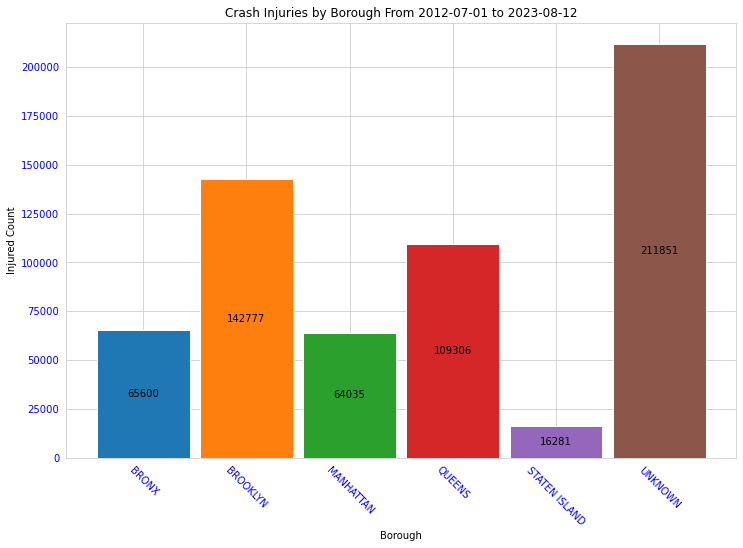

In [ ]:
#| hide
# Create a plot using Matplotlib with details on the number of people injured, by borough, since records began.

persons_injured_by_borough = crash.groupby(by=["BOROUGH"])["NUM_PERSONS_INJURED"].sum()
boroughs = persons_injured_by_borough.index

width = 0.9
y_pos = np.arange(len(persons_injured_by_borough))
x_pos = np.arange(len(boroughs))
inj_bars = plt.bar(y_pos, persons_injured_by_borough, width, color=bar_colors)

plt.bar_label(inj_bars, label_type="center", fmt="%d")
plt.xticks(x_pos, boroughs)
plt.title("Crash Injuries by Borough From {0} to {1}".format(start_date, end_date))
plt.xlabel("Borough")
plt.ylabel("Injured Count")
plt.xticks(rotation=315)
plt.show()

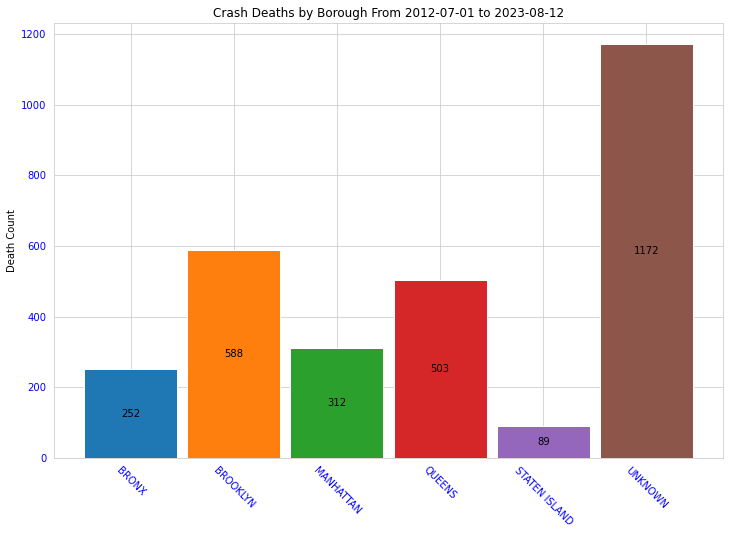

In [ ]:
# | hide
# Create a plot using Matplotlib with details on the number of people killed, by borough, since records began.

persons_killed_by_borough = crash.groupby(by=["BOROUGH"])["NUM_PERSONS_KILLED"].sum()

boroughs = persons_killed_by_borough.index

width = 0.9
y_pos = np.arange(len(persons_killed_by_borough))
x_pos = np.arange(len(boroughs))
k_bars = plt.bar(y_pos, persons_killed_by_borough, width, color=bar_colors)

plt.bar_label(k_bars, label_type="center", fmt="%d")
plt.xticks(x_pos, boroughs)
plt.title("Crash Deaths by Borough From {0} to {1}".format(start_date, end_date))
plt.ylabel("Death Count")
plt.xticks(rotation=315)

plt.show()

#| hide
### Borough Chart Results

From the two charts, we can see that Brooklyn leads the city in crash deaths and injuries. 
The "UNKNOWN" borough has is the highest total overall. Unfortunately, we don't know where those collisions should be. 
A future project may be to find the borough based on the "ZIP_CODE" or "LOCATION" if available.


##### Create some new columns, YEAR, MONTH_NAME, DAY_NAME and HOUR

In [ ]:
# |code-fold: true
# | code-summary: Code - Create new columns, YEAR, MONTH_NAME, DAY_NAME and HOUR
#  by extracting information from the *DATE* column

# Set up some date columns: YEAR, MONTH_NAME, DAY_NAME, HOUR
# Remove all records for 2012 as it's only a partial year.

crash["YEAR"] = crash["DATE"].dt.year

# Get rid of 2012 as it only has 6 months of data
no_2012_mask = crash["YEAR"] > 2012
crash = crash[no_2012_mask]

# Reset the start_date variable to reflect the change
start_date = crash["DATE"].dt.date.min()
year_order = crash["YEAR"].sort_values().unique()

# Create a MONTH_NAME column. Actually, month abbreviated name
crash["MONTH_NAME"] = crash["DATE"].dt.month_name().str[0:3]

# Create a HOUR column, which reflects the hour of day that the collision occurred
crash["HOUR"] = crash["DATE"].dt.strftime("%H")

# Need to convert hour_order to a Python list instead of Numpy array
hour_order = crash["HOUR"].sort_values().unique().tolist()

crash["DAY_NAME"] = crash["DATE"].dt.strftime("%a")

print("Year, Month and Hour order lists will be used for charting.")
print("Year order: {}\n".format(year_order))
print("Month abbreviations: {}\n".format(crash.MONTH_NAME.unique()))
print("Hour order: {}\n".format(hour_order))

Year, Month and Hour order lists will be used for charting.
Year order: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]

Month abbreviations: ['Sep' 'Mar' 'Jun' 'Dec' 'Apr' 'Jul' 'Feb' 'Aug' 'Nov' 'May' 'Jan' 'Oct']

Hour order: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']



#### Chart the Yearly Collision Injuries and Deaths
  
> This chart will give an overview of the total deaths and injuries on NYC roads.

In [ ]:
#| code-fold: true
#| code-summary: Code - Create the yearly Killed/Injured collections.

crash_by_year_killed = (
    crash.groupby("YEAR")["NUM_PERSONS_KILLED"].sum().sort_values(ascending=False)
)
crash_by_year_injured = (
    crash.groupby("YEAR")["NUM_PERSONS_INJURED"].sum().sort_values(ascending=False)
)

In [ ]:
#| hide

print("5 Worst Years for Collision Deaths")
print(crash_by_year_killed.head(5))
print("\n5 Worst Years for Collision Injuries")
print(crash_by_year_injured.head(5))

5 Worst Years for Collision Deaths
YEAR
2013    297
2021    296
2022    287
2020    269
2014    262
Name: NUM_PERSONS_KILLED, dtype: int64

5 Worst Years for Collision Injuries
YEAR
2018    61941
2019    61389
2017    60656
2016    60317
2013    55124
Name: NUM_PERSONS_INJURED, dtype: int64


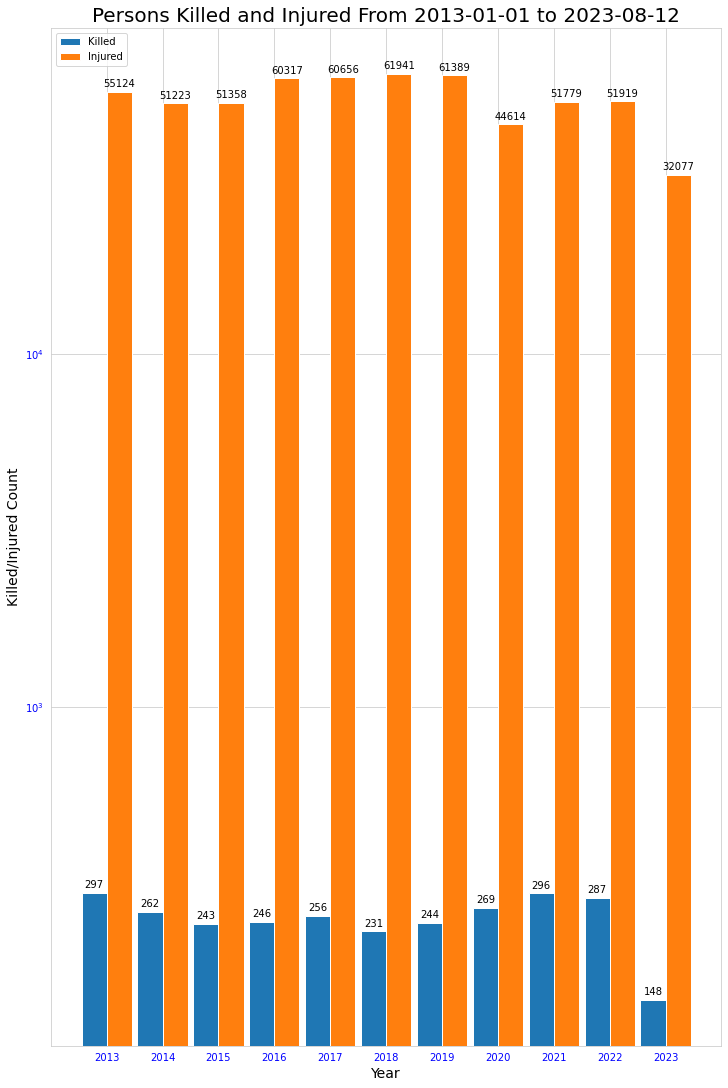

In [ ]:
#| code-fold: true
#| code-summary: Code - Create Matplotlib bar chart with yearly details on the number of people killed and injured.

killed_injured = {
    "Killed": crash_by_year_killed.loc[year_order],
    "Injured": crash_by_year_injured.loc[year_order],
}

x_loc = np.arange(len(year_order))  # the label locations
width = 0.45  # the width of the bars
multiplier = 0
fig, ax = plt.subplots(figsize=(10, 15), layout="constrained")

# Create the Injured/Killed bars for each year
for killed_or_injured, count in killed_injured.items():
    offset = width * multiplier
    rects = ax.bar(x_loc + offset, count, width, label=killed_or_injured)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Killed/Injured Count", fontsize=14)
ax.set_title(
    "Persons Killed and Injured From {0} to {1}".format(start_date, end_date),
    fontsize=20,
)
ax.set_xticks(x_loc + (width / 2), year_order)
ax.legend(loc="upper left")
ax.set_yscale("log")
plt.show()

##### Collision Injuries and Deaths since 2013

The chart shows that traffic fatalities had a general downward trend from the high of 297 in 2013 to a low of 231 in 2018. The trend is upwards from 2019 to 2021, which was just 1 off the worst year, 2013. 
For injuries, 2016 to 2019 were the worst. The following years are a slight improvement, but no visible downward trend yet. 

##### Combine Killed + Injured Counts into one 'CASUALTIES' column
> For each category, Person, Pedestrian, Cyclist and Motorist there will be a new 'CASUALTY' column with the combined Injured/Killed values
>
> The new columns are, ***PERSON_CASUALTY_COUNT***, ***PEDESTRIAN_CASUALTY_COUNT***, ***CYCLIST_CASUALTY_COUNT*** and ***MOTORIST_CASUALTY_COUNT***


In [ ]:
#| code-fold: true
#| code-summary: Code - Combine the INJURED and KILLED columns into one 'CASUALTIES' column.

crash["PERSON_CASUALTY_COUNT"] = crash.NUM_PERSONS_INJURED + crash.NUM_PERSONS_KILLED
crash["PEDESTRIAN_CASUALTY_COUNT"] = (
    crash.NUM_PEDESTRIANS_INJURED + crash.NUM_PEDESTRIANS_KILLED
)

crash["CYCLIST_CASUALTY_COUNT"] = crash.NUM_CYCLISTS_INJURED + crash.NUM_CYCLISTS_KILLED
crash["MOTORIST_CASUALTY_COUNT"] = (
    crash.NUM_MOTORISTS_INJURED + crash.NUM_MOTORISTS_KILLED
)

killed_injured_mask = (crash.NUM_PERSONS_KILLED > 0) & (crash.NUM_PERSONS_INJURED > 0)

In [ ]:
# |hide
# Check that it looks good
crash[killed_injured_mask][
    ["NUM_PERSONS_KILLED", "NUM_PERSONS_INJURED", "PERSON_CASUALTY_COUNT"]
]

,NUM_PERSONS_KILLED,NUM_PERSONS_INJURED,PERSON_CASUALTY_COUNT
COLLISION_ID,,,
4407693,1,4,5
4457151,1,1,2
4457192,1,2,3
4457191,1,3,4
4487497,1,1,2
...,...,...,...
4642411,1,2,3
4642632,1,1,2
4643193,2,4,6


##### Function ```show_values```
> A function to print value counts above or to the side of Barchart bars.  
I got the original function from this very useful site, [statology.org](https://www.statology.org).  
> 
> [The original function is here](https://www.statology.org/seaborn-barplot-show-values/).  

In [ ]:
#| code-fold: true
#| code-summary: Code - Function to print value counts above or to the side of barchart bars


def show_values(axs, orient="v", space=0.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height() * 0.01)
                value = "{:6,.0f}".format(p.get_height())
                ax.text(_x, _y, value, ha="center", fontsize=12)
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height() * 0.5)
                value = "{:6,.0f}".format(p.get_width())
                ax.text(_x, _y, value, ha="left", fontsize=12)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [ ]:
# |code-fold: true
# | code-summary: Code - Helper functions for creating multiple charts based on Grouped statistics.

# Statistics will be created for the below columns.
#   PERSON_CASUALTY_COUNT
#   PEDESTRIAN_CASUALTY_COUNT
#   CYCLIST_CASUALTY_COUNT
#   MOTORIST_CASUALTY_COUNT


def create_grouped_casualty_data_by_category(
    victim_categories, time_group="YEAR", order_list=None
):
    """
    Create multiple Seaborn SubPlot charts based on:
    PERSON_CASUALTY_COUNT, PEDESTRIAN_CASUALTY_COUNT, CYCLIST_CASUALTY_COUNT and MOTORIST_CASUALTY_COUNT
    time_group can be 'HOUR', 'DAY_OF_WEEK', 'MONTH_NAME', 'YEAR'
    """
    time_group = time_group.upper()
    all_casualty_data = []

    for category in victim_categories:
        cat_upper = category.upper()
        casualty_label = cat_upper + "_CASUALTY_COUNT"

        casualty_data = crash.groupby(by=[time_group], as_index=True).agg(
            {casualty_label: "sum"}
        )
        if order_list and len(order_list):
            casualty_data = casualty_data.loc[order_list]

        category_data = {
            "category": category,
            "casualty_label": casualty_label,
            "casualty_data": casualty_data,
        }

        all_casualty_data.append(category_data)
    return all_casualty_data


def create_bar_plots_for_casualty_data(sns, axes, order_list, crash_victims_data):
    for idx, category_data in enumerate(crash_victims_data):
        xlabel = None
        ylabel = None
        # Casualty Chart
        category_title = category_data["category"].title()
        chart_title = "{0} Casualties".format(category_title)

        casualty_max = category_data["casualty_data"][
            category_data["casualty_label"]
        ].max()
        casualty_values = category_data["casualty_data"][
            category_data["casualty_label"]
        ].to_list()

        casualty_colors = [
            "k" if (x >= casualty_max) else "tab:red" for x in casualty_values
        ]

        ax = axes[idx]

        sns.barplot(
            data=category_data["casualty_data"],
            x=order_list,
            order=order_list,
            y=category_data["casualty_label"],
            palette=casualty_colors,
            ax=ax,
        ).set(title=chart_title, xlabel=xlabel, ylabel=ylabel)

        show_values(axes)

In [ ]:
# |code-fold: true
# | code-summary: Code - Set some global Matplotlib/Seaborn chart variables.
title_fontsize = 20
label_fontsize = 18
# For spacing between charts on the same grid
gridspec_kw = {"wspace": 0.1, "hspace": 0.1}

sns.set_style("whitegrid")

### What was the worst year for traffic collision casualties?

2018 was the worst for human casualties, with 62,172 injuries and deaths. 2019 was a close second, followed by 2017 and 2016.  

- **Cyclists** - 2020 was by far the worst year with 5,605 casualties.
- **Motorists** - 2018 was their worst year with 46,168 casualties. 
- **Pedestrians** - 2013 was their worst year with 12,164 casualties. Things have improved a little for them since then.  


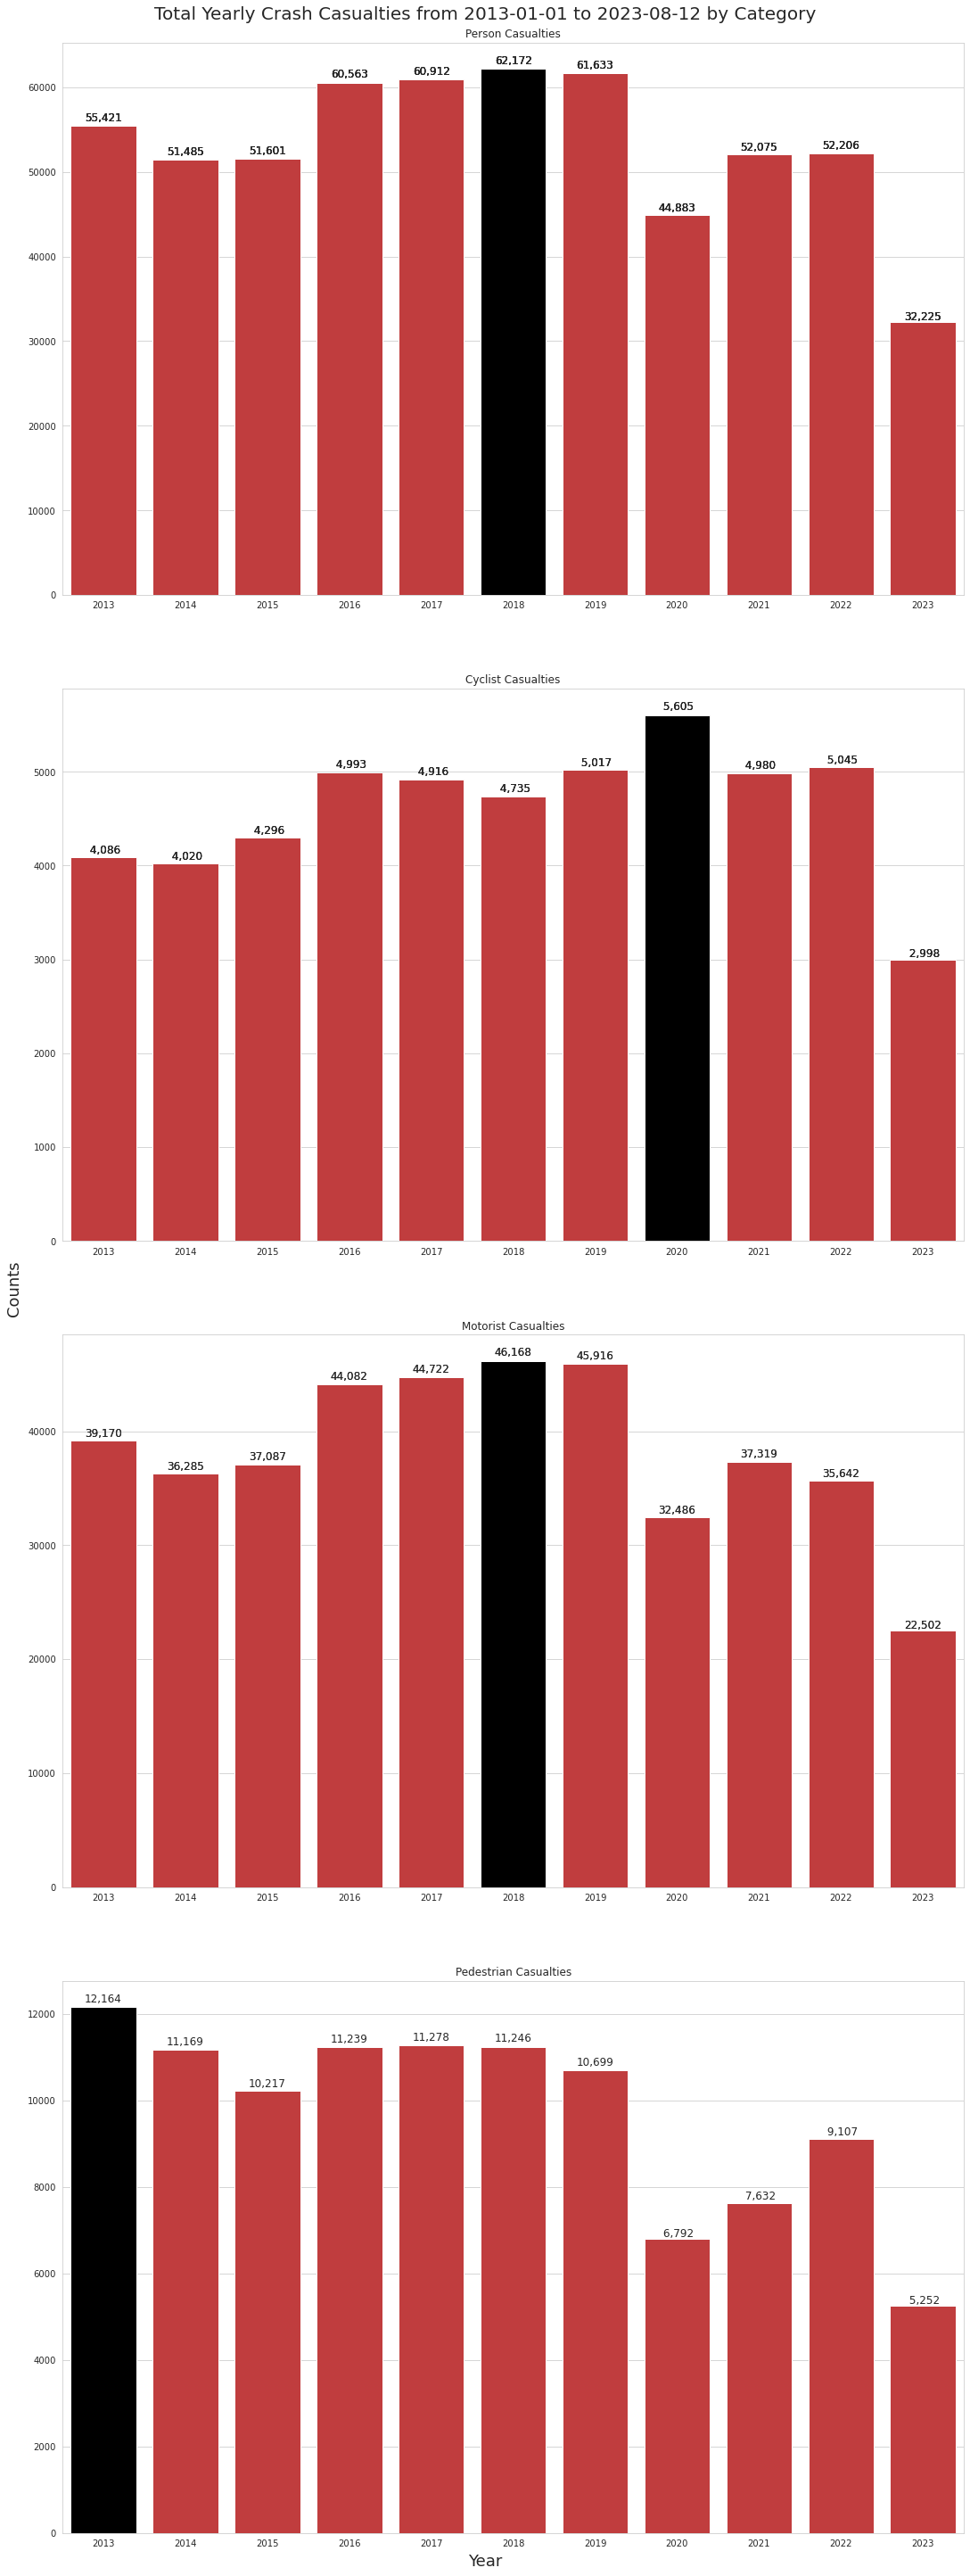

In [ ]:
# |code-fold: true
# |code-summary: Code - Create Seaborn charts for crash casualties based on year.

col_ct = 1
#  Create the outer figure box
fig, axes = plt.subplots(
    4, col_ct, figsize=(15, 40), layout="constrained", gridspec_kw=gridspec_kw
)
fig.suptitle(
    "Total Yearly Crash Casualties from {0} to {1} by Category".format(
        start_date, end_date
    ),
    fontsize=title_fontsize,
)
fig.supxlabel("Year", fontsize=label_fontsize)
fig.supylabel("Counts", fontsize=label_fontsize)

crash_casualty_data = create_grouped_casualty_data_by_category(
    victim_categories, "year"
)
create_bar_plots_for_casualty_data(sns, axes, year_order, crash_casualty_data)

### What are the worst months for traffic collision casualties? 

June has been the worst month for human casualties, with 56,240 injuries and deaths.  
The Summer months in general seem to be bad for motorists and cyclists, while winter is bad for pedestrians.
  
- **Cyclists** - July has been the worst, with 6,270 casualties. August and June follow after that.
- **Motorists** - July has been the worst, with 41,140 casualties. June is a close second.
- **Pedestrians** - December has been the worst, with 10,750 casualties. January is a close second. 
  - Winter time may be a good time to stay on public transport or indoors.
    

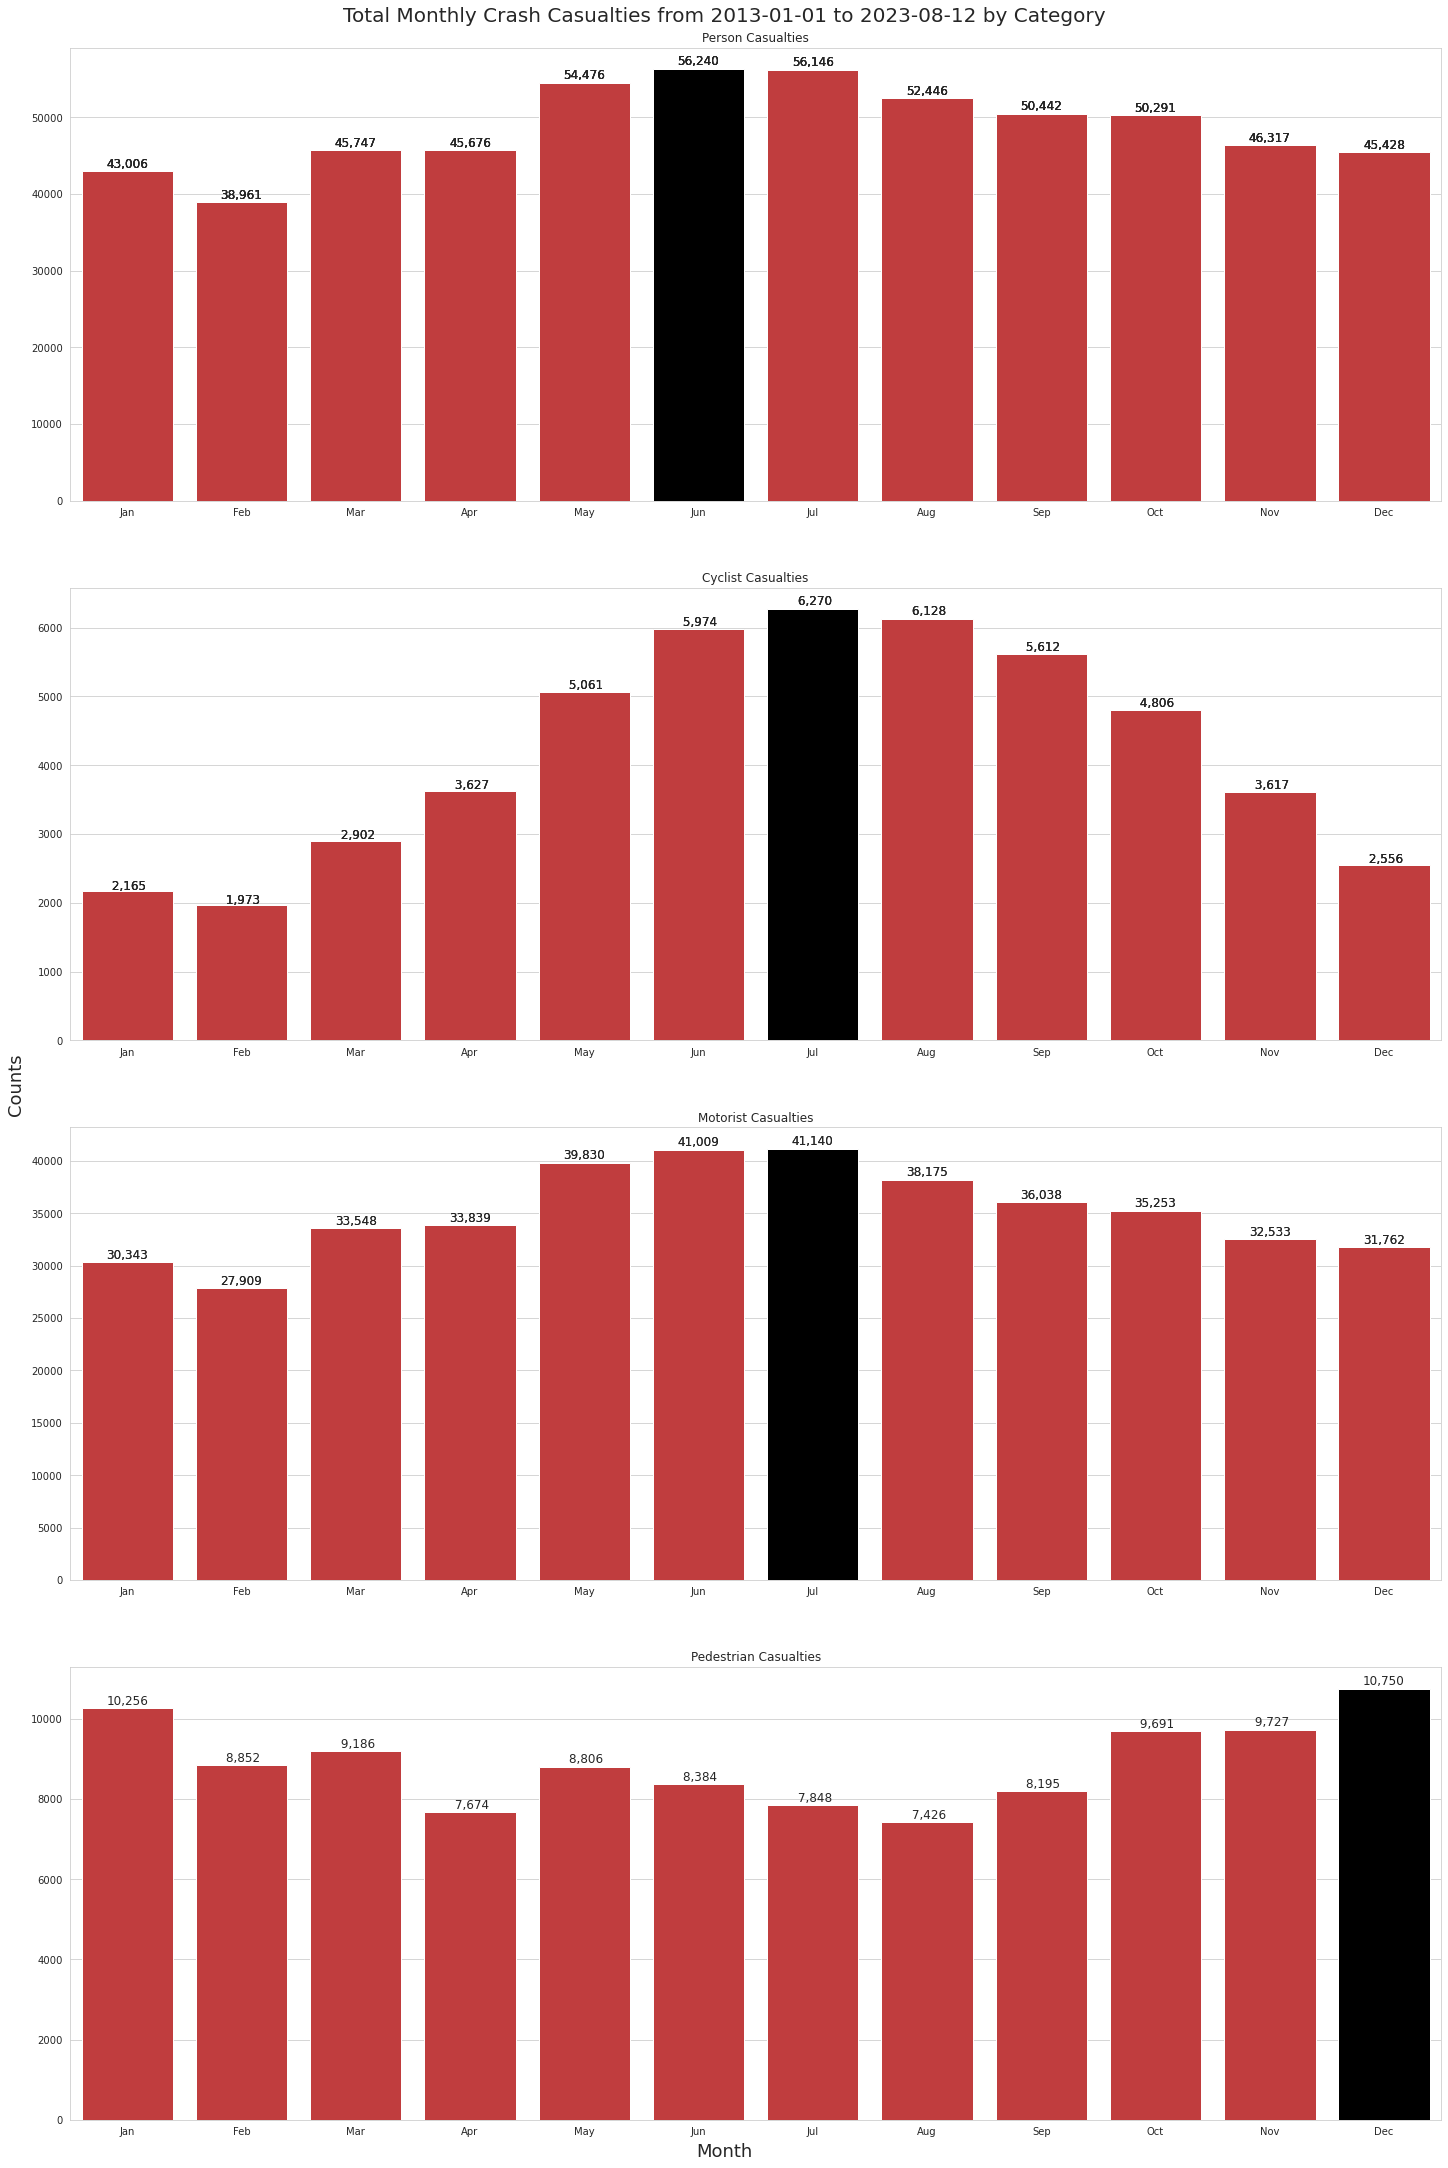

In [ ]:
# |code-fold: true
# |code-summary: Code - Create Seaborn charts for crash casualties based on month.

# Create the outer figure box
col_ct = 1
fig, axes = plt.subplots(
    4, col_ct, figsize=(20, 30), layout="constrained", gridspec_kw=gridspec_kw
)

fig.suptitle(
    "Total Monthly Crash Casualties from {0} to {1} by Category".format(
        start_date, end_date
    ),
    fontsize=title_fontsize,
)
fig.supxlabel("Month", fontsize=label_fontsize)
fig.supylabel("Counts", fontsize=label_fontsize)

crash_casualty_data = create_grouped_casualty_data_by_category(
    victim_categories, "month_name", month_abbr_order
)
create_bar_plots_for_casualty_data(sns, axes, month_abbr_order, crash_casualty_data)

### What day of the week should you avoid going out?

Friday tends to be the worst day for human casualties, with 90,089 injuries and deaths.
Sunday seems to be the safest.
  
- **Cyclists** - Friday is a bad day to bike in NYC, with 8,008 casualties since the start of 2013.
- **Motorists** - Friday and Saturday are equally bad, with 63,774 casualties each.
- **Pedestrians** - Pedestrians should also avoid Fridays, with 17,337 casualties since the start of 2013.


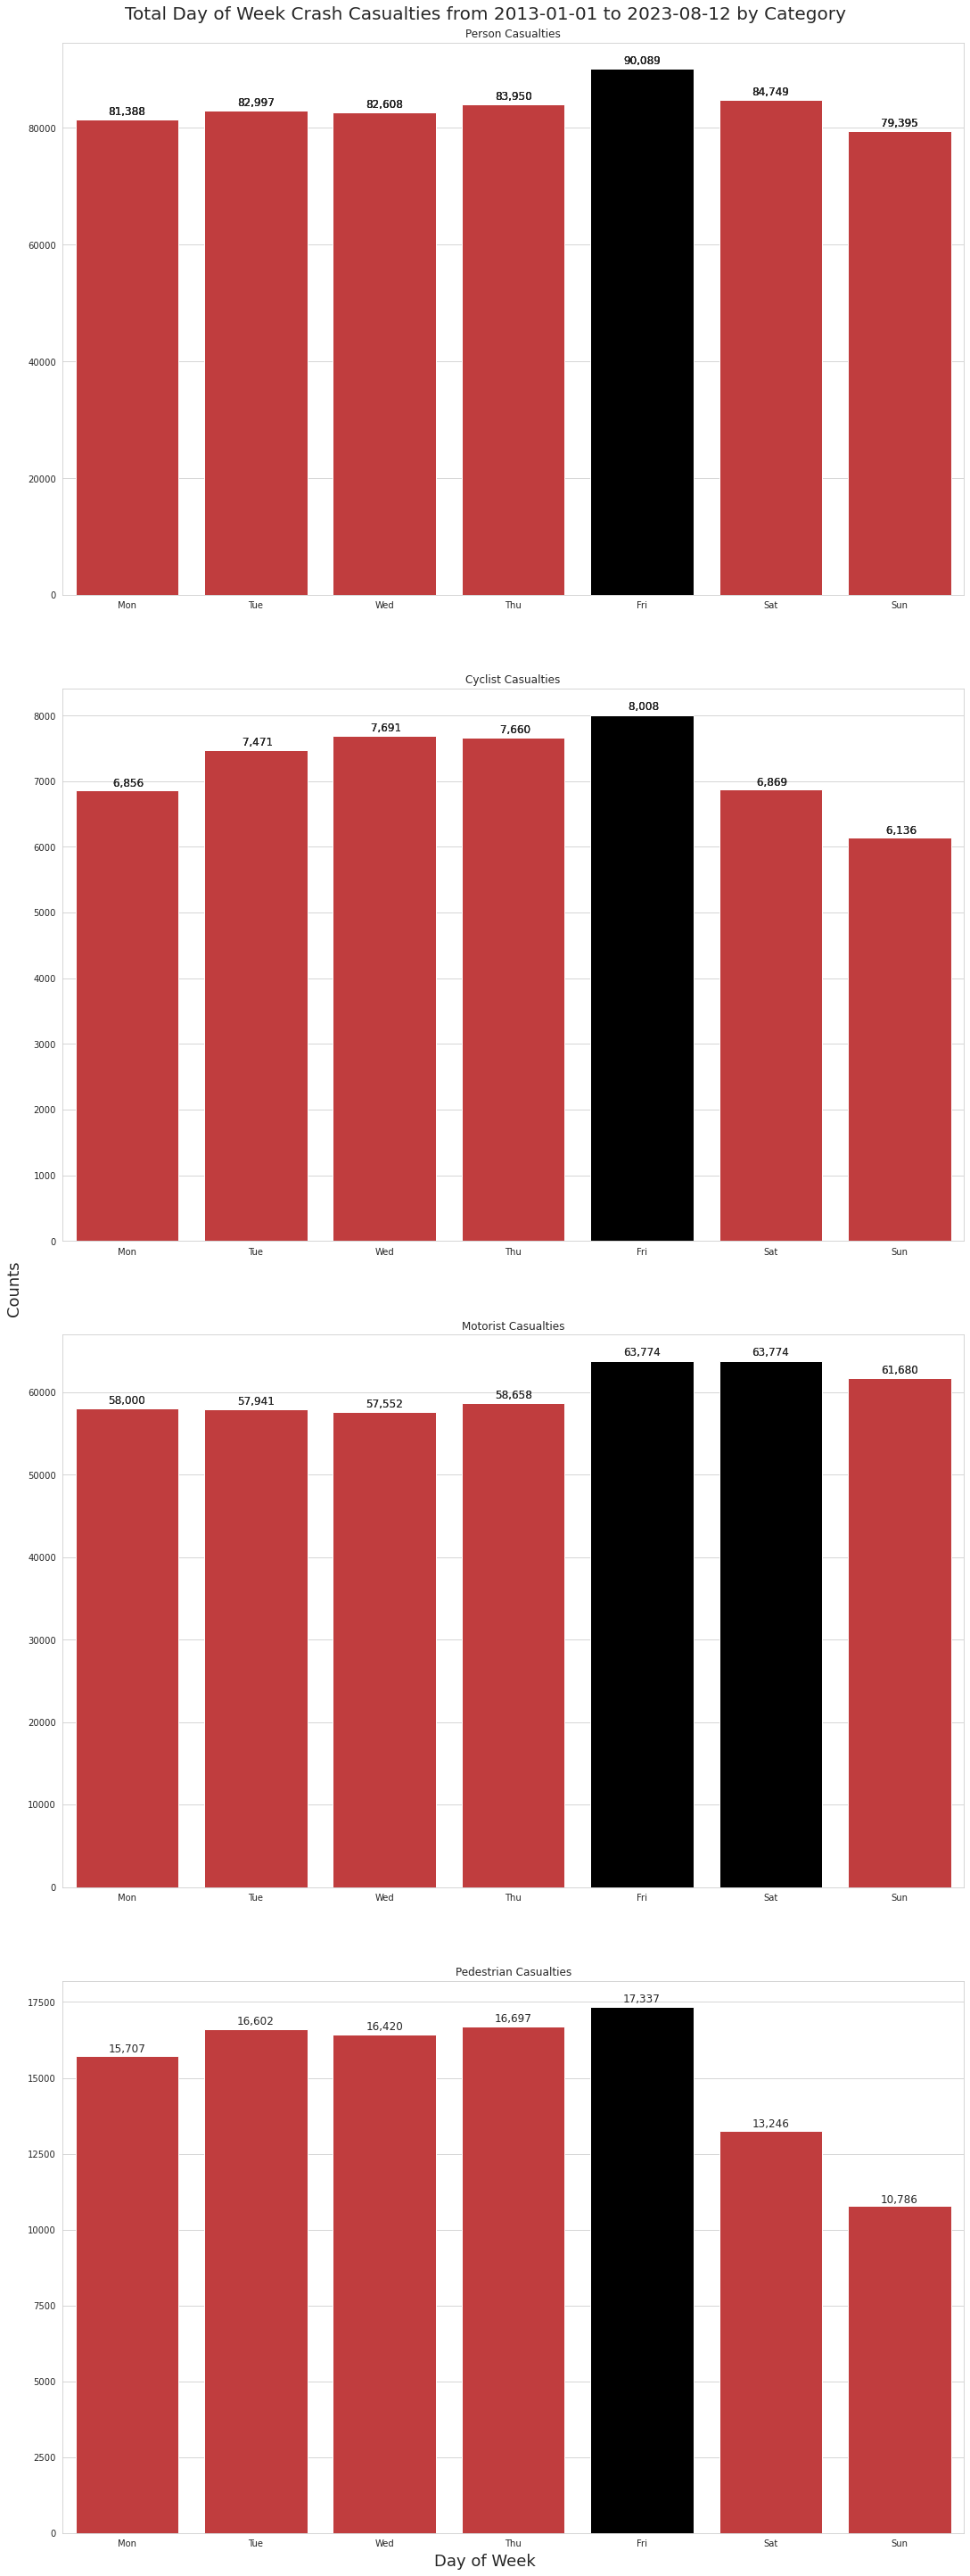

In [ ]:
# |code-fold: true
# |code-summary: Code - Create Seaborn charts for crash casualties based on day of the week.

col_ct = 1
fig, axes = plt.subplots(
    4, col_ct, figsize=(15, 40), layout="constrained", gridspec_kw=gridspec_kw
)

fig.suptitle(
    "Total Day of Week Crash Casualties from {0} to {1} by Category".format(
        start_date, end_date
    ),
    fontsize=title_fontsize,
)
fig.supxlabel("Day of Week", fontsize=label_fontsize)
fig.supylabel("Counts", fontsize=label_fontsize)

# crash.set_index('MONTH_NAME').loc[month_abbr_order].groupby(by=['MONTH_NAME']).agg({'PEDESTRIAN_CASUALTY_COUNT': 'sum'}).plot(kind='bar')
crash_casualty_data = create_grouped_casualty_data_by_category(
    victim_categories, "day_name", day_abbr_order
)
crash_casualty_data
create_bar_plots_for_casualty_data(sns, axes, day_abbr_order, crash_casualty_data)

### What hour of the day should make you stay away?

The hour between 5 and 6 pm is the worst time for human casualties, with 40,777 injuries and deaths. The rush-hour times around 5 pm have a high casualty count. The morning rush hour also trends higher, but much lower than the evening rush-hour.  
The early hours of the morning between 12 and 1 am also having a high body count. This is at a time when you would expect the traffic volume to be low. 

- **Cyclists** - Follow the trend with 4,167 casualties between 5 and 6 pm.
- **Motorists** - Get off to an earlier start, with 28,142 casualties between 4 and 5 pm.
- **Pedestrians** - Pedestrians get hit at higher rates between 5 and 6 pm, with 8,6623 casualties since the start of 2013.

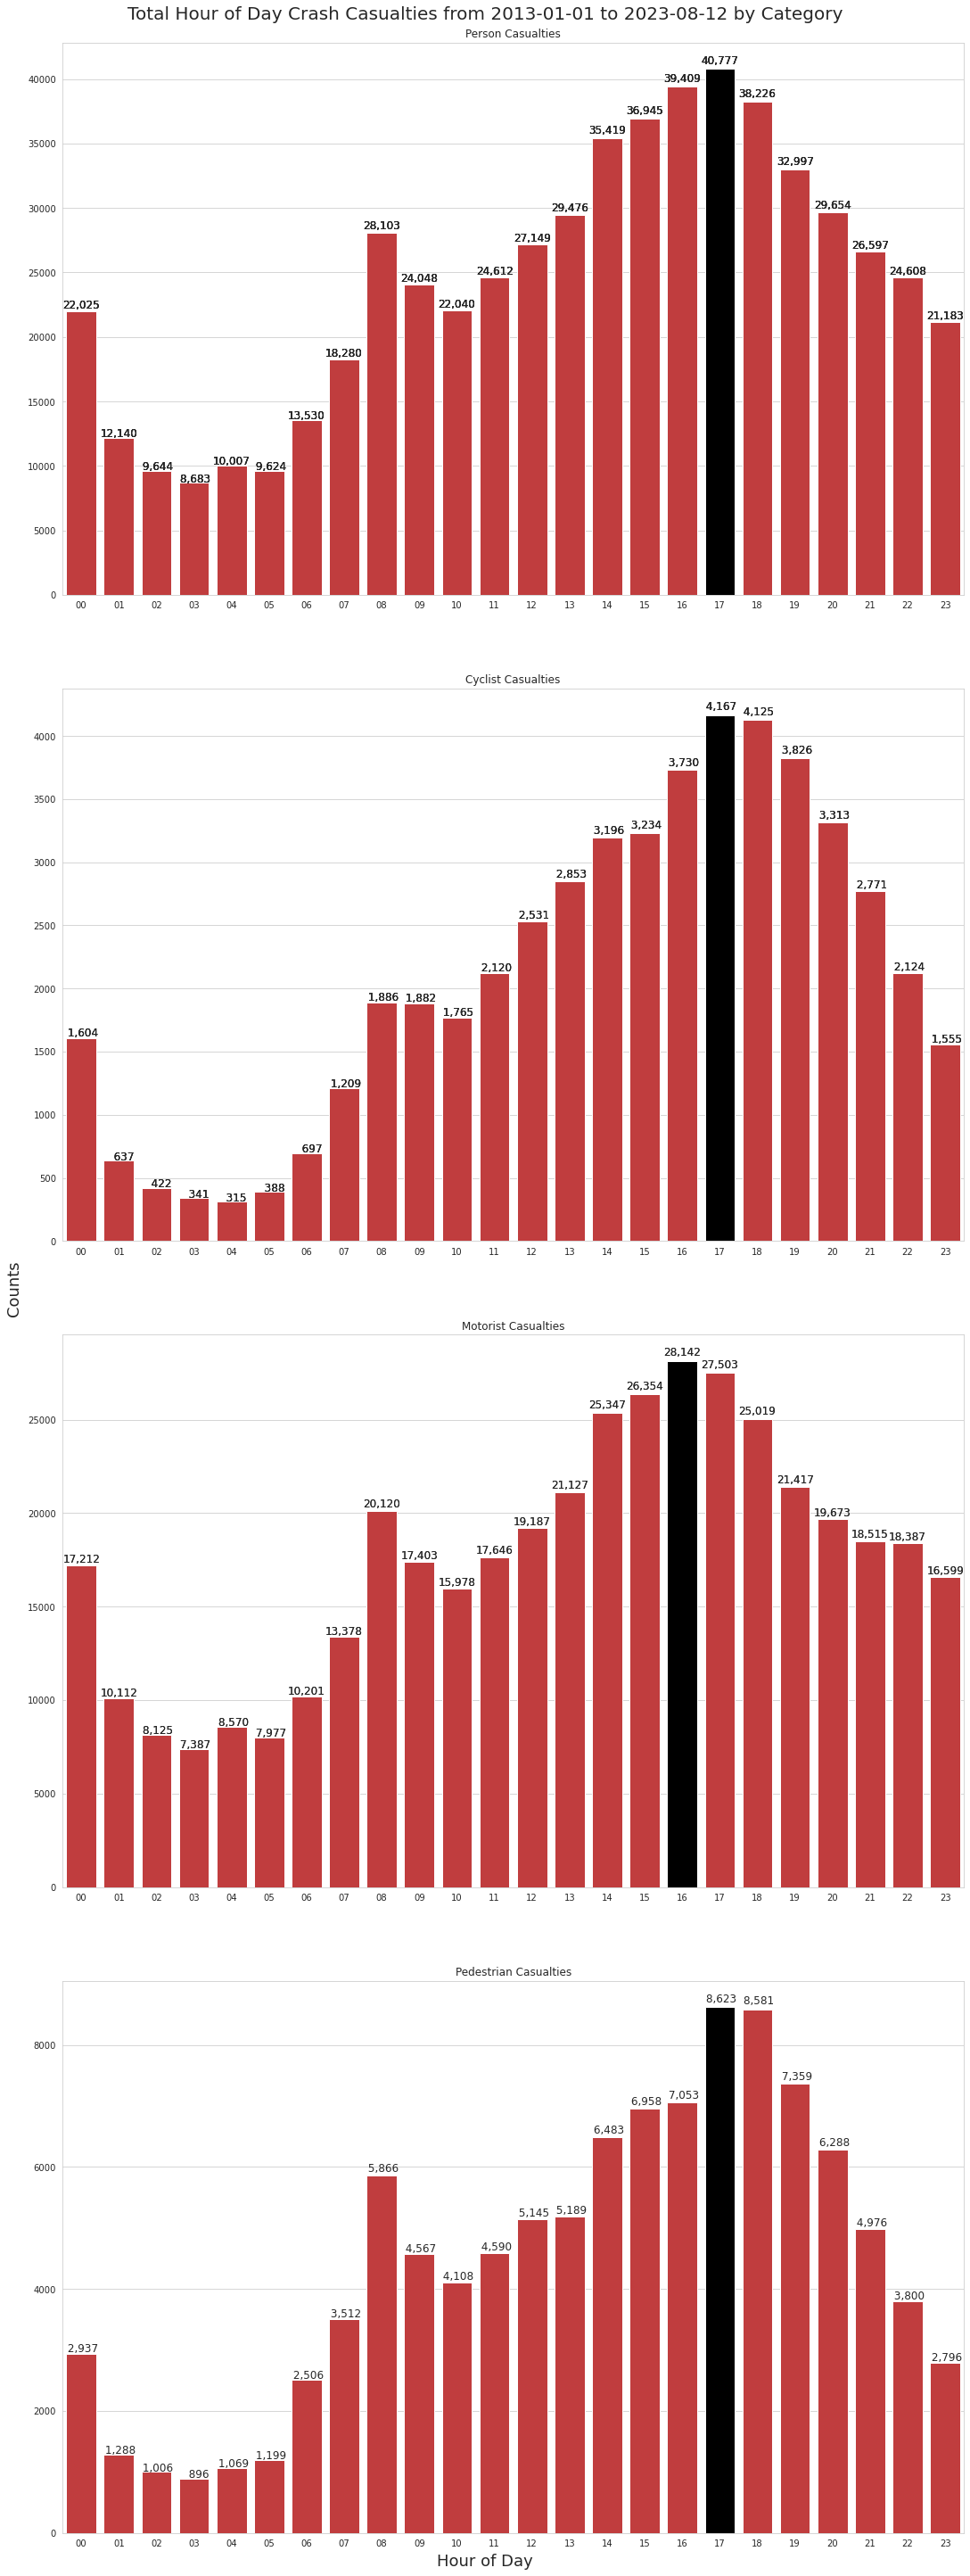

In [ ]:
# |code-fold: true
# |code-summary: Code - Create Seaborn charts for crash casualties based on the Hour of day.

#  Create the outer figure box
col_ct = 1
fig, axes = plt.subplots(
    4, col_ct, figsize=(15, 40), layout="constrained", gridspec_kw=gridspec_kw
)

fig.suptitle(
    "Total Hour of Day Crash Casualties from {0} to {1} by Category".format(
        start_date, end_date
    ),
    fontsize=title_fontsize,
)
fig.supxlabel("Hour of Day", fontsize=label_fontsize)
fig.supylabel("Counts", fontsize=label_fontsize)

crash_casualty_data = create_grouped_casualty_data_by_category(
    victim_categories, "hour", hour_order
)

#  Create the inner charts
create_bar_plots_for_casualty_data(sns, axes, hour_order, crash_casualty_data)

### Conclusion
No major surprises with most of the data. Most injuries and deaths occur during the evening rush hour, when traffic volume is at its highest and people are in a rush to get home. This is particularly evident on Fridays, when the urge to get home seems to be the greatest.  

I'm still curious as to why more motorist casualties on Saturday are equal to the Friday's total. It could be because of Friday night "madness" or some other reason. I'd like to spend more time digging into that.   

It's also not too surprising that the cyclists are getting mowed down more often in the Summer months, as there are probably a lot more bikes on the road during those times.   

For pedestrians, the upward trend in casualties from October to January is a little surprising. The December peak may be because of holiday shopping and holiday parties? That's something I'll spend more time analyzing in the future.


### Links
[This Project on GitHub](https://github.com/aibistin/crash_stats)  
[Me on Linkedin](https://www.linkedin.com/in/austin-kenny-87515311/)  

#### More Info
[NYC Streetsblog](https://nyc.streetsblog.org/)  
[HellgateNYC](https://hellgatenyc.com/)  
[NYC Open Data](https://opendata.cityofnewyork.us/)  
[**nbdev** really helped setup this blog post](https://nbdev.fast.ai/)
